## CNN (PyTorch Implementation)

In [9]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [10]:
%run data.ipynb

Data root: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\input
Total Trainable Data:  112120
Training set size:  60
Validation set size:  20
Test set size:  20
Images path: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\input
Training batches: 2
Validation batches: 1
Test batches: 1


In [11]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [12]:
# Hyperparameters
learning_rate = 1e-4
weight_decay = 1e-6
num_epochs = 10
num_classes = 15

In [13]:
# Simple CNN Model defined in PyTorch
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNClassifier, self).__init__()
        # Input: 3 x 224 x 224
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=0), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=0), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Calculate size after convolutions
        # 224 -> Conv(3x3) -> 222 -> Pool(2x2) -> 111
        # 111 -> Conv(3x3) -> 109 -> Pool(2x2) -> 54
        self.flatten_size = 64 * 54 * 54
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_auc': [],
        'val_auc': []
    }
    
    best_val_auc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training Phase
        model.train()
        running_loss = 0.0
        all_targets = []
        all_outputs = []
        
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            # For AUC calculation
            all_targets.append(labels.cpu().detach().numpy())
            all_outputs.append(torch.sigmoid(outputs).cpu().detach().numpy())
            
        epoch_loss = running_loss / len(train_loader.dataset)
        all_targets = np.vstack(all_targets)
        all_outputs = np.vstack(all_outputs)
        
        # Calculate AUC only for classes with both positive and negative samples
        try:
            # Find classes with both 0s and 1s
            valid_classes = []
            for i in range(all_targets.shape[1]):
                if len(np.unique(all_targets[:, i])) > 1:
                    valid_classes.append(i)
            
            if len(valid_classes) > 0:
                epoch_auc = roc_auc_score(
                    all_targets[:, valid_classes], 
                    all_outputs[:, valid_classes], 
                    average='macro'
                )
            else:
                epoch_auc = 0.0
        except ValueError:
            epoch_auc = 0.0
            
        history['train_loss'].append(epoch_loss)
        history['train_auc'].append(epoch_auc)
        
        print(f'Train Loss: {epoch_loss:.4f} AUC: {epoch_auc:.4f}')
        
        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        val_targets = []
        val_outputs = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                val_targets.append(labels.cpu().numpy())
                val_outputs.append(torch.sigmoid(outputs).cpu().numpy())
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_targets = np.vstack(val_targets)
        val_outputs = np.vstack(val_outputs)
        
        # Calculate AUC only for classes with both positive and negative samples
        try:
            valid_classes = []
            for i in range(val_targets.shape[1]):
                if len(np.unique(val_targets[:, i])) > 1:
                    valid_classes.append(i)
            
            if len(valid_classes) > 0:
                val_auc = roc_auc_score(
                    val_targets[:, valid_classes], 
                    val_outputs[:, valid_classes], 
                    average='macro'
                )
            else:
                val_auc = 0.0
        except ValueError:
            val_auc = 0.0
            
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        
        print(f'Val Loss: {val_loss:.4f} AUC: {val_auc:.4f}')
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), os.path.join("files", "cnn_model.pth"))
            print("Model saved!")
            
    return history

In [15]:
# Initialize model, criterion, and optimizer
model = CNNClassifier(num_classes=num_classes).to(device)
criterion = nn.BCEWithLogitsLoss() # Better numerical stability than BCELoss
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Run training
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5045 AUC: 0.5263


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.4366 AUC: 0.5998
Model saved!
Epoch 2/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3039 AUC: 0.6341


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.4821 AUC: 0.5776
Epoch 3/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2914 AUC: 0.6595


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.4785 AUC: 0.5645
Epoch 4/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2890 AUC: 0.6520


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.4531 AUC: 0.5721
Epoch 5/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2534 AUC: 0.7475


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.4370 AUC: 0.5613
Epoch 6/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2464 AUC: 0.7846


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.4204 AUC: 0.5586
Epoch 7/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2376 AUC: 0.8175


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.4040 AUC: 0.5717
Epoch 8/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2243 AUC: 0.8681


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.4039 AUC: 0.5780
Epoch 9/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2181 AUC: 0.8951


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.4120 AUC: 0.5786
Epoch 10/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2121 AUC: 0.8961


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.4208 AUC: 0.5847


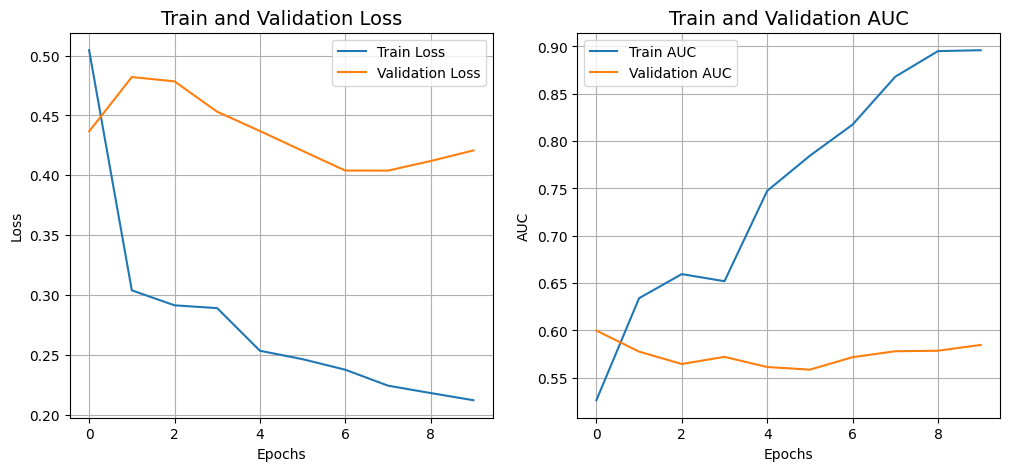

In [16]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2) 
    plt.plot(history['train_auc'], label='Train AUC')
    plt.plot(history['val_auc'], label='Validation AUC')
    plt.title('Train and Validation AUC', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid()

    plt.show()

plot_history(history)